In [25]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
import os
from IPython.display import Image
from IPython.core.display import HTML 
from IPython.display import SVG, display

In [12]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [13]:
N = 1000
X, y = make_moons(N, noise=0.1, random_state=42)

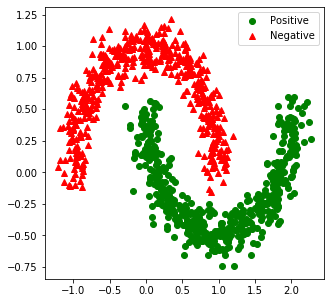

In [14]:
plt.figure(figsize=(5,5))
plt.plot(X[y == 1, 0], X[y == 1, 1], 'go', label="Positive")
plt.plot(X[y == 0, 0], X[y == 0, 1], 'r^', label="Negative")
plt.legend()
plt.show()

In [15]:
m, n = X.shape
X_plus_bias = np.c_[np.ones((m, 1)), X]

y = y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X_plus_bias, y, test_size=0.2, random_state=42)

In [16]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))
learning_rate = 0.01

def log_dir(prefix="", root_logdir = "tf2_logs"):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

def fetch_batch(X_train, y_train, epoch, batch_index, batch_size):
    m, n = X_train.shape
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = X_train[indices]
    y_batch = y_train[indices]
    return X_batch, y_batch

def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()

    return y_proba, loss, training_op, loss_summary, init, saver

In [17]:
reset_graph()

n_inputs = 2
logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [18]:
checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(X_train, y_train, epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 0.7929015
Epoch: 500 	Loss: 0.26691636
Epoch: 1000 	Loss: 0.2531865
Epoch: 1500 	Loss: 0.24945237
Epoch: 2000 	Loss: 0.24794973
Epoch: 2500 	Loss: 0.24734432
Epoch: 3000 	Loss: 0.246887
Epoch: 3500 	Loss: 0.24693897
Epoch: 4000 	Loss: 0.24679409
Epoch: 4500 	Loss: 0.2465642
Epoch: 5000 	Loss: 0.24701862
Epoch: 5500 	Loss: 0.24651377
Epoch: 6000 	Loss: 0.24676515
Epoch: 6500 	Loss: 0.24665888
Epoch: 7000 	Loss: 0.24643959
Epoch: 7500 	Loss: 0.2465101
Epoch: 8000 	Loss: 0.24638127
Epoch: 8500 	Loss: 0.24636208
Epoch: 9000 	Loss: 0.24640888
Epoch: 9500 	Loss: 0.24670266
Epoch: 10000 	Loss: 0.24660729


In [19]:
y_pred = (y_proba_val >= 0.5)

In [20]:
precision_score(y_test, y_pred)

0.8490566037735849

In [21]:
recall_score(y_test, y_pred)

0.9

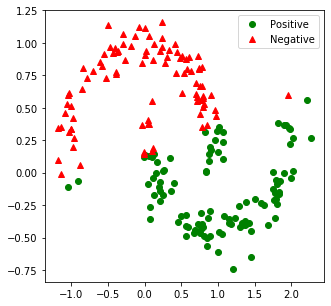

In [22]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector

plt.figure(figsize=(5,5))
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

In [23]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
#%reload_ext tensorboard

In [24]:
tensorboard --logdir tf2_logs --host localhost

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 24636.

# Mesmo com todas as tentativas possíveis que utilizei para ajustar o Jupyter e meu computador,
# creio que foi necessário abandonar o ensaio.
# Estou tratando de ajustar tudo e vou assumir que possivelmente a sequência estava no caminho esperado!